# Paris Olympics News Analysis
The objective of this program is to gather news articles in the lead up to the Paris Olympics and analyze them.
1) Get top 100 headlines related to sports and Olympics for each day from one year prior to the end of the Olympics up to the closing date, i.e., 12 August 2023 to 12 August 2024.

2) The articles will be analyzed and segregated based on sentiment of the article towards the Olympics:
   - Positive sentiment
   - Negative sentiment
<br><br>
3) The articles with negative sentiment will further be analysed to determine if the negative sentiment is attributable to Seine river.<br>
4) A stacked area-chart will be created with the bottom layer representing the percentage of Siene-related negative news and the top layer representing the percentage of non-Siene-related negative news.

In [6]:
import json

import urllib.request
import urllib.response

import pandas as pd
import numpy as np
import time
from matplotlib import pyplot as plt
import transformers
from transformers import AutoTokenizer
from transformers import Trainer, TrainingArguments, DistilBertForSequenceClassification, DistilBertTokenizerFast, DataCollatorWithPadding, pipeline
from transformers import AutoModelForSequenceClassification
from datetime import datetime, timedelta
from datasets import Dataset, DatasetDict
import torch
import os

import requests
from bs4 import BeautifulSoup

from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split

C:\Users\draw0004\anaconda3\envs\AdditionalLibraries\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
RETREIVE_ARTICLES_FROM_GNEWS = False
USE_SAVED_MODEL = False
DETERMINE_IMAGE_REL_ARTICLES = True

## 1. Gather the news articles
The news articles have been gather using the GNews API (https://gnews.io/).

### 1.1 Function to invoke the end-points to get articles

In [8]:
def get_top_olympics_articles(date_from = None, date_to = None, print_how_many = 3):

    APIKEY = "81a8f293ff4b6e6bb4157f5f5945ed04"
    #URL = f"https://gnews.io/api/v4/search?q={search_term}&lang=en&max=10&from={date_from}&to={date_to}&apikey={APIKEY}"
    URL = f"https://gnews.io/api/v4/top-headlines?q=olympics&category=sports&lang=en&max=100&from={date_from}&to={date_to}&apikey={APIKEY}"
        
    with urllib.request.urlopen(URL) as response:
        
        data_dict = json.loads(response.read().decode("utf-8"))
        article_list = data_dict["articles"]
        
        for i in range(len(article_list)):
    
            if i < print_how_many:
                print(f"Article {i+1}")
                print(f"Title: {article_list[i]['title']}")
                print(f"Description: {article_list[i]['description']}")
                print(f"Content: {article_list[i]['content']}")
                print(f"URL: {article_list[i]['url']}\n")
                            
            else:
                continue
                
    return article_list

In [9]:
date_from = '2023-07-26T00:00:00Z'
date_to = '2024-08-11T23:59:59Z'

In [10]:
if RETREIVE_ARTICLES_FROM_GNEWS == True:

    #This is just a test logic.    
    search_term = "Olympics"
    sort_by = 'publishedAt'

    article_list = get_top_olympics_articles(date_from = date_from, date_to = date_to, print_how_many = 3)

### 1.2 Repeated invocation of the function to download the required number of articles
Each invocation will, at the most, return only 10 articles.

In [11]:
sort_by = 'publishedAt'

In [12]:
#Load articles saved in previous runs.
if os.path.exists("articles.json"):
    
    with open("articles.json", "r", encoding="utf-8") as f:
        article_list = json.load(f)
        article_copy_list = []
        date_range = pd.date_range(start=pd.to_datetime(date_from).strftime("%Y-%m-%d"), end=pd.to_datetime(date_to).strftime("%Y-%m-%d"))
        
        for article_dict in article_list:
            article_dict.pop('expanded content', None)
            article_dict.pop('content sentiment', None)
            
            if pd.to_datetime(article_dict['publishedAt']).strftime("%Y-%m-%d") in date_range:
                article_copy_list.append(article_dict)

    article_list = article_copy_list
                
else:
    #Add newly read articles to the list of existing articles.
    article_list = []

In [13]:
if RETREIVE_ARTICLES_FROM_GNEWS == True:

    article_date_set = set()
    
    #Based on articles loaded from previous runs, what is the period we should be retrieving articles for?
    #We first add dates from these previously loaded articles to the 'article_date_set' set.
    for article_dict in article_list:
        article_date = pd.to_datetime(article_dict['publishedAt']).strftime("%Y-%m-%d")
        article_date_set.add(article_date)
    
    #The starting period will always be the following.
    date_from_text = '2023-08-12T00:00:00Z'
    date_from = pd.to_datetime(date_from_text)

    #The period up to which we should be now reading articles depends on whether we have any previously loaded articles or not.
    
    #Articles have been read in the past. Determine the date up to which articles need to be read based on these past articles.
    if len(article_date_set ) > 0:
    
        min_date = (min(pd.to_datetime(date_str) for date_str in article_date_set) - timedelta(1))
        date_to_text = min_date.strftime("%Y-%m-%d") + "T" + "23:59:59Z"
        date_to = pd.to_datetime(date_to_text)
    
    #Articles have not been read in the past. In this case, the articles will be read up to the closing date of the Olympics.
    else:
        
        date_to_text = '2024-08-12T23:59:59Z'
        date_to = pd.to_datetime(date_to_text)
        
    print(f"In this run, we'll attempt to read articles between the period {date_from_text} to {date_to_text}.")    

In [14]:
if RETREIVE_ARTICLES_FROM_GNEWS == True:

    count = 0
    
    RETRIEVAL_SUCCESS = 1            #1: Successful retrieval of articles
    PARTIAL_RETRIEVAL_SUCCESS = 2    #2: Partially successful retrieval of articles
    FAILED_RETRIEVAL_SUCCESS = 3     #3: Failed retrieval of articles
    
    article_retreival_status = -1

    #In each iteration of the loop below, we'll be reading top 100 articles in the sports category with 'Olympics' as the keyword for a particular day.
    #This day will be shifted one position to the left in each iteration.
    curr_date_to = date_to
    curr_date_from = date_to - timedelta(1)
    
    #Keep reading for consecutive days going further back from the closing date of the Paris Olympics.
    while curr_date_from >= date_from:
    
        curr_date_from_text = curr_date_from.strftime("%Y-%m-%d") + 'T' + '00:00:00' + 'Z'
        curr_date_to_text = curr_date_to.strftime("%Y-%m-%d") + 'T' + curr_date_to.strftime("%H:%M:%S") + 'Z'
        
        #Get articles for the current 1 day period.
        print(f"Retrieving articles for the day {curr_date_from_text} - {curr_date_to_text}")
        
        try:
            time.sleep(1) #Delay of 1 second between successive requests for articles.
            curr_date_article_list = get_top_olympics_articles(date_from = curr_date_from_text, date_to = curr_date_to_text, print_how_many = 1)
            
        except urllib.error.HTTPError as e:
            
            #403	Forbidden -- You have reached your daily quota, the next reset is at 00:00 UTC.
            if e.code == 403:
                article_retreival_status = PARTIAL_RETRIEVAL_SUCCESS
                print(e)
                break
                
            #429	Too Many Requests -- You have made more requests per second than you are allowed.
            elif e.code == 429:
                article_retreival_status = PARTIAL_RETRIEVAL_SUCCESS
                print(e)
                break
                #Introduce delay of 1 second
    
            #400	Bad Request -- Your request is invalid.
            #401	Unauthorized -- Your API key is wrong.
            #500	Internal Server Error -- We had a problem with our server. Try again later.
            #503    Service Unavailable -- We're temporarily offline for maintenance. Please try again later.
            elif e.code in [400, 401, 500, 503]:
                article_retreival_status = FAILED_RETRIEVAL_SUCCESS
                print(e)
                break
    
            else:
                #Continue processing.
                article_retreival_status = RETRIEVAL_SUCCESS
                pass
        
        print(f"Number of articles read for the current day = {len(curr_date_article_list)}")
        article_list.extend(curr_date_article_list)
        
        #Increment the count of articles.
        count += len(curr_date_article_list)
        
        #Shift the period one day behing.
        curr_date_from  = pd.to_datetime(curr_date_from) - timedelta(1)
        curr_date_to = pd.to_datetime(curr_date_to)  - timedelta(1)
        
        print("------------------------------------------------------\n") 

In [15]:
if RETREIVE_ARTICLES_FROM_GNEWS == True:

    if article_retreival_status == FAILED_RETRIEVAL_SUCCESS:
        raise Exception("Article retreival failed completely. Try again later!")
    
    elif article_retreival_status == PARTIAL_RETRIEVAL_SUCCESS:
        print("Article retreival partially successful. Subsequent program runs will be needed.")
    
    elif article_retreival_status == RETRIEVAL_SUCCESS:
        print("Article retreival successful. Subsequent program runs NOT needed.")

print(f"Total number of articles (ready previously + read today) = {len(article_list)}")

Total number of articles (ready previously + read today) = 8462


### 1.3 Save the articles read to file

In [16]:
if RETREIVE_ARTICLES_FROM_GNEWS == True:
    
    # Save the updated list back to the file
    with open("articles.json", "w", encoding="utf-8") as f:
        json.dump(article_list, f, ensure_ascii=False, indent=4)

## 2. Determine whether the articles pertain to topics that impact the public perception of the Paris Olympics.

### 2.1 Read the labelled data and convert it to suitable form

In [17]:
if USE_SAVED_MODEL == False:
    
    #Load articles saved in previous runs.
    if os.path.exists("Labelled Data - Article Image Relevance.json"):
        
        with open("Labelled Data - Article Image Relevance.json", "r", encoding="utf-8") as f:
              categorized_article_list = json.load(f)

In [18]:
if USE_SAVED_MODEL == False:

    #Number of rows of labelled data.
    input_text_list = []
    label_list = []
    unique_label_list = ['NO', 'YES']
    
    for categorized_article in categorized_article_list:
    
        input_text_list.append(categorized_article['title'].strip() + '. ' + categorized_article['description'].strip())
        label_list.append(categorized_article['organization related'])
    
    encoded_label_list = [unique_label_list.index(label) for label in label_list]
    
    print(f"Number of rows of input text = {len(input_text_list)}, labels = {len(label_list)}, encoded labels = {len(encoded_label_list)}")
    print(f"The unique label values are {np.unique(label_list)}")
    
    print(f"First five input texts:")
    print(input_text_list[0:5])
    print(f"\nFirst five labels:")
    print(label_list[0:5])
    print(f"\nFirst five encoded labels:")
    print(encoded_label_list[0:5])

Number of rows of input text = 575, labels = 575, encoded labels = 575
The unique label values are ['NO' 'YES']
First five input texts:
['Kayak Cross at Olympics is the Best Sibling Drama of 2024. The only thing I know about Kayak Cross for certain after an hour or so of watching it is that it is the most compelling TV I’ve seen in 2024.', "Illness and withdrawals ahead of mixed relay triathlon. Belgium have withdrawn from Monday's mixed relay triathlon at the Paris Olympics citing an illness for athlete Claire Michel amid reports it is a case of E. coli.", 'NBC and Peacock Earn Viewership Gold. The numbers are in, and by NBC and Peacock’s “total audience delivery” rating, Olympics viewership shot up dramatically from Tokyo and other Olympiads as well. Here’s our full breakdown of the ratings.', 'Paris Olympics Closing Ceremony Doubles Tokyo Audience. The Paris Olympics concluded the 2024 Games with a highly viewed Closing Ceremony, which brought in 20.8 million viewers', 'Sinéad Diver

In [19]:
if USE_SAVED_MODEL == False:

    train_texts, test_texts, train_labels, test_labels = train_test_split(input_text_list, encoded_label_list, test_size = 0.2, stratify = encoded_label_list, random_state = 42)
    
    train_dataset = Dataset.from_dict({
                                        "input_text": train_texts,
                                        "label": train_labels})
    test_dataset = Dataset.from_dict({
                                        "input_text": test_texts,
                                        "label": test_labels})

    categorized_article_dataset = DatasetDict({
                                                "train": train_dataset,
                                                "test": test_dataset})

### 2.2 Train and test the pretrained model

In [20]:
def pre_process_function(examples):
    return tokenizer(examples['input_text'], truncation = True)

In [21]:
def compute_metrics(eval_pred):

    logits, labels = eval_pred
    preds = np.argmax(logits, axis = -1)

    acc = accuracy_score(y_pred = preds, y_true = labels)
    f1 = f1_score(y_pred = preds, y_true = labels, average='binary')
    precision = precision_score(y_pred = preds, y_true = labels, average='binary')
    recall = recall_score(y_pred = preds, y_true = labels, average='binary')
    
    return {
        "accuracy": acc,
        "f1": f1,
        "precision": precision,
        "recall": recall
    }

In [22]:
transformers.set_seed(42)

In [23]:
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

if USE_SAVED_MODEL == False:
    
    tokenized_cat_article_dataset = categorized_article_dataset.map(pre_process_function, batched=True)
    tokenized_cat_article_dataset['train']
    
    data_collator = DataCollatorWithPadding(tokenizer = tokenizer)

Map: 100%|██████████| 115/115 [00:00<00:00, 7536.17 examples/s]


In [24]:
if USE_SAVED_MODEL == False:

    seq_clf_model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels = len(unique_label_list))
    seq_clf_model.config.id2label = {i: l for i, l in enumerate(unique_label_list)}

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [25]:
#Training model and testing on validation set.
if USE_SAVED_MODEL == False:

    epochs = 10
    training_args = TrainingArguments(
                            #output_dir = "./article_classifier/results",
                            num_train_epochs = epochs,
                            per_device_train_batch_size = 32, #len(tokenized_cat_article_dataset['train']),
                            per_device_eval_batch_size = len(tokenized_cat_article_dataset['test']),
                            load_best_model_at_end = True,
                            seed = 42,
                            warmup_steps = len(tokenized_cat_article_dataset['train'])//5,
                            weight_decay = 0.05,
                            logging_steps = 1,
                            log_level = 'info',
                            eval_strategy = 'epoch',
                            save_strategy = 'epoch',
                            metric_for_best_model = 'f1'
                        )
    
    trainer = Trainer(
        model = seq_clf_model,
        args = training_args,
        train_dataset = tokenized_cat_article_dataset['train'],
        eval_dataset = tokenized_cat_article_dataset['test'],
        compute_metrics = compute_metrics,
        data_collator = data_collator
    )
    
    trainer.train()

The following columns in the training set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: input_text. If input_text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 460
  Num Epochs = 10
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 150
  Number of trainable parameters = 66,955,010


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.678500,0.560073,0.904348,0.000000,0.000000,0.000000
2,0.591100,0.311365,0.904348,0.000000,0.000000,0.000000
3,0.097800,0.238764,0.904348,0.000000,0.000000,0.000000
4,0.218300,0.263980,0.895652,0.250000,0.400000,0.181818
5,0.007700,0.288004,0.913043,0.375000,0.600000,0.272727
6,0.004800,0.374909,0.895652,0.250000,0.400000,0.181818
7,0.003800,0.375303,0.930435,0.555556,0.714286,0.454545
8,0.002600,0.422077,0.921739,0.470588,0.666667,0.363636
9,0.000700,0.446816,0.921739,0.470588,0.666667,0.363636
10,0.000900,0.412505,0.930435,0.555556,0.714286,0.454545


The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: input_text. If input_text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.

***** Running Evaluation *****
  Num examples = 115
  Batch size = 115
C:\Users\draw0004\anaconda3\envs\AdditionalLibraries\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Saving model checkpoint to trainer_output\checkpoint-15
Configuration saved in trainer_output\checkpoint-15\config.json
Model weights saved in trainer_output\checkpoint-15\model.safetensors
Saving Trainer.data_collator.tokenizer by default as Trainer.processing_class is `None`
tokenizer config file saved 

In [26]:
if USE_SAVED_MODEL == False:

    seq_clf_model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels = len(unique_label_list))
    seq_clf_model.config.id2label = {i: l for i, l in enumerate(unique_label_list)}

    #Train on the complete data
    full_dataset = Dataset.from_dict({"input_text": input_text_list, "label": encoded_label_list})
    tokenized_full_dataset = full_dataset.map(pre_process_function, batched=True)
    
    training_args = TrainingArguments(
                            output_dir = "./article_classifier/results",
                            num_train_epochs = 8,
                            per_device_train_batch_size = 32, #len(tokenized_cat_article_dataset['train']),
                            seed = 42,
                            warmup_steps = len(tokenized_full_dataset)//5,
                            weight_decay = 0.05,
                            logging_strategy = 'epoch',
                            log_level = 'info',
                            eval_strategy = 'no',
                            save_strategy = 'epoch')
    
    trainer = Trainer(
        model = seq_clf_model,
        args = training_args,
        train_dataset = tokenized_full_dataset,
        compute_metrics = compute_metrics,
        data_collator = data_collator
    )
    
    trainer.train()
    trainer.save_model("./article_classifier/final_model")

loading configuration file config.json from cache at C:\Users\draw0004\.cache\huggingface\hub\models--distilbert-base-uncased\snapshots\12040accade4e8a0f71eabdb258fecc2e7e948be\config.json
Model config DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.51.3",
  "vocab_size": 30522
}

loading weights file model.safetensors from cache at C:\Users\draw0004\.cache\huggingface\hub\models--distilbert-base-uncased\snapshots\12040accade4e8a0f71eabdb258fecc2e7e948be\model.safetensors
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertF

Step,Training Loss
18,0.671000
36,0.409600
54,0.283200
72,0.178200
90,0.095900
108,0.028400
126,0.005900
144,0.016000


Saving model checkpoint to ./article_classifier/results\checkpoint-18
Configuration saved in ./article_classifier/results\checkpoint-18\config.json
Model weights saved in ./article_classifier/results\checkpoint-18\model.safetensors
Saving Trainer.data_collator.tokenizer by default as Trainer.processing_class is `None`
tokenizer config file saved in ./article_classifier/results\checkpoint-18\tokenizer_config.json
Special tokens file saved in ./article_classifier/results\checkpoint-18\special_tokens_map.json
Saving model checkpoint to ./article_classifier/results\checkpoint-36
Configuration saved in ./article_classifier/results\checkpoint-36\config.json
Model weights saved in ./article_classifier/results\checkpoint-36\model.safetensors
Saving Trainer.data_collator.tokenizer by default as Trainer.processing_class is `None`
tokenizer config file saved in ./article_classifier/results\checkpoint-36\tokenizer_config.json
Special tokens file saved in ./article_classifier/results\checkpoint-36\

In [27]:
pipe = pipeline("text-classification", "./article_classifier/final_model", tokenizer = tokenizer)

#Test with some examples
print(pipe("Sandeep Singh: An Olympic shooting dream visualised at his frozen Siachen post. The 28-year-old Armyman topped the 10m air rifle trials against far higher rated rivals to bag a Paris Games spot"))
print(pipe("High jumper Nicola Olyslagers: ‘I want to do something I’ve never done before’. The Australian is pushing herself to new heights as she prepares for a tilt at Olympic glory in Paris – and personal fulfilment"))
print(pipe("Paris Olympics Closing Ceremony Doubles Tokyo Audience. The Paris Olympics concluded the 2024 Games with a highly viewed Closing Ceremony, which brought in 20.8 million viewers"))
print(pipe("Teenager arrested in France on suspicion of Olympics attack plot. Interior ministry says 18-year-old Chechen suspected of planning ‘Islamist-inspired’ attack in Saint-Étienne"))
print(pipe("French sports minister swims in Seine River ahead of Paris Olympics. French sports minister Amélie Oudéa-Castéra has taken a symbolic dip in the Seine in a bid to ease concerns about water quality before the start of the Paris..."))

loading configuration file ./article_classifier/final_model\config.json
Model config DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "NO",
    "1": "YES"
  },
  "initializer_range": 0.02,
  "label2id": null,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "problem_type": "single_label_classification",
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "torch_dtype": "float32",
  "transformers_version": "4.51.3",
  "vocab_size": 30522
}

loading configuration file ./article_classifier/final_model\config.json
Model config DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
 

[{'label': 'NO', 'score': 0.9991588592529297}]
[{'label': 'NO', 'score': 0.9991520643234253}]
[{'label': 'YES', 'score': 0.9938179850578308}]
[{'label': 'YES', 'score': 0.9939447045326233}]
[{'label': 'YES', 'score': 0.9940987825393677}]


### 2.3 Filter out articles that do NOT pertain to topics that impact the public perception of the Paris 2024 Olympics 

In [62]:
if DETERMINE_IMAGE_REL_ARTICLES == True:

    image_rel_article_list = []
    
    for article in article_list:
    
        text_to_be_classified = article['title'] + '. ' + article['description']
        test_class_dict = pipe(text_to_be_classified)[0]
        if test_class_dict['label'] == 'YES':
            image_rel_article_list.append(article)
    
    print(f"Number of articles relevant to the Olympics = {len(image_rel_article_list)}")
    print(f"\nLet's take a look at the title and the description of the first five articles:")
    
    for index in range(5):
        print(image_rel_article_list[index]['title'])
        print(image_rel_article_list[index]['description'])
        print("----------------------------------------------")

Number of articles relevant to the Olympics = 451

Let's take a look at the title and the description of the first five articles:
'City of Light' was star of Olympics show
'City of Light' was star of Olympics show
----------------------------------------------
I’ve covered 10 Olympics over 32 years. These Paris Games outdid them all
With thrilling competition, spectacular venues and viral moments the 2024 Paris Games more than delivered.
----------------------------------------------
Star-studded closing ceremony brings 2024 Paris Olympics to end with a flourish
Paris closed out two and a half extraordinary weeks of Olympic sports and emotion with a boisterous, star-studded show in France’s national stadium on Sunday, handing over hosting duties for the Summer Games to the next city in line: Los Angeles in 2028.
----------------------------------------------
Olympics closing ceremony: 5 takeaways from an extremely memorable party
It was a party in the Stade de France as an electric two

In [63]:
if DETERMINE_IMAGE_REL_ARTICLES == True:
    
    with open('image_rel_articles.json', 'w', encoding='utf-8') as f:
        json.dump(image_rel_article_list, f, ensure_ascii=False, indent=4)

## 3. Sentiment analysis on the articles

In [67]:
# Save the updated list back to the file
with open("image_rel_articles_classified.json", "r", encoding="utf-8") as f:
      image_rel_articles_classified_list = json.load(f)

In [68]:
num_class_articles = len(image_rel_articles_classified_list)
print(f"Total number of classified articles = {num_class_articles}")

Total number of classified articles = 231


### 3.1 Analyse content sentiment

In [69]:
def get_statistics_by_sentiment(article_list):

    num_pos_sent = 0
    num_neut_sent = 0
    num_neg_sent = 0

    pos_sent_article_list = []
    neut_sent_article_list = []
    neg_sent_article_list = []

    for article_dict in article_list:
        try:
            if article_dict['content sentiment'] == 'POSITIVE':
                pos_sent_article_list.append(article_dict)
                num_pos_sent = len(pos_sent_article_list)
                
            elif article_dict['content sentiment'] == 'NEUTRAL':
                neut_sent_article_list.append(article_dict)
                num_neut_sent = len(neut_sent_article_list)
                
            else:
                neg_sent_article_list.append(article_dict)
                num_neg_sent = len(neg_sent_article_list)
                
        except KeyError as ke:
            print(article_dict)
            break

    
    return num_pos_sent, pos_sent_article_list, num_neut_sent, neut_sent_article_list, num_neg_sent, neg_sent_article_list

In [70]:
num_pos_sent, pos_sent_article_list, num_neut_sent, neut_sent_article_list, num_neg_sent, neg_sent_article_list = get_statistics_by_sentiment(image_rel_articles_classified_list)

print(f"Number of positive article = {num_pos_sent}, Percentage = {round(num_pos_sent/num_class_articles*100, 2)}")
print(f"Number of neutral articles = {num_neut_sent}, Percentage = {round(num_neut_sent/num_class_articles*100, 2)}")
print(f"Number of negative articles = {num_neg_sent}, Percentage = {round(num_neg_sent/num_class_articles*100, 2)}")

Number of positive article = 84, Percentage = 36.36
Number of neutral articles = 35, Percentage = 15.15
Number of negative articles = 112, Percentage = 48.48


In [71]:
print("Let's look at one of the articles classified as positive:")
print(pos_sent_article_list[0])

print("\nLet's look at one of the articles classified as neutral:")
print(neut_sent_article_list[0])

print("\nLet's look at one of the articles classified as negative:")
print(neg_sent_article_list[0])

Let's look at one of the articles classified as positive:
{'title': "'City of Light' was star of Olympics show", 'description': "'City of Light' was star of Olympics show", 'content': 'With its venues throughout the city and stunning backdrops, Paris will kickstart a whole new era in cities wanting to host the Olympic Games. PHOTO: AFP\nWhat was the star of one of the "all-time great" Olympics? It was quite simply Paris, due to the ... [3326 chars]', 'url': 'https://tribune.com.pk/story/2487364/city-of-light-was-star-of-olympics-show', 'image': 'https://i.tribune.com.pk/media/images/111723417671-2/111723417671-2.jpg', 'publishedAt': '2024-08-11T23:16:18Z', 'source': {'name': 'The Express Tribune', 'url': 'https://tribune.com.pk'}, 'content sentiment': 'POSITIVE', 'environment related': 'NO', 'waterway related': 'NO'}

Let's look at one of the articles classified as neutral:
{'title': 'Day 16: What to watch with Team Canada at Paris 2024', 'description': 'Paris 2024 is coming to a close

### 3.2 Analyse environment relevance

In [72]:
def get_statistics_by_env_rel(article_list):

    num_env_rel = 0
    num_non_env_rel = 0
    
    env_rel_list = []
    non_env_rel_list = []
    
    for article_dict in article_list:
        if article_dict['environment related'] == 'YES':
            env_rel_list.append(article_dict)
            num_env_rel = len(env_rel_list)
            
        else:
            non_env_rel_list.append(article_dict)
            num_non_env_rel = len(non_env_rel_list)

    
    return num_env_rel, env_rel_list, num_non_env_rel, non_env_rel_list

In [73]:
num_env_rel, env_rel_list, num_non_env_rel, non_env_rel_list = get_statistics_by_env_rel(image_rel_articles_classified_list)

print(f"Number of environment-relevant articles = {num_env_rel}, Percentage = {round(num_env_rel/num_class_articles*100, 2)}")
print(f"Number of non environment-relevant articles = {num_non_env_rel}, Percentage = {round(num_non_env_rel/num_class_articles*100, 2)}")

Number of environment-relevant articles = 54, Percentage = 23.38
Number of non environment-relevant articles = 177, Percentage = 76.62


### 3.3 Analyse environment relevance by content sentiment

#### 3.3.1 Analyse environment relevance for positive articles

In [74]:
num_pos_env_rel, pos_env_rel_list, num_pos_non_env_rel, pos_non_env_rel_list = get_statistics_by_env_rel(pos_sent_article_list)

print(f"Number of positive environment-relevant articles = {num_pos_env_rel}, Percentage = {round(num_pos_env_rel/num_pos_sent*100, 2)}")
print(f"Number of positive non environment-relevant articles = {num_pos_non_env_rel}, Percentage = {round(num_pos_non_env_rel/num_pos_sent*100, 2)}")

Number of positive environment-relevant articles = 12, Percentage = 14.29
Number of positive non environment-relevant articles = 72, Percentage = 85.71


#### 3.3.2 Analyse environment relevance for neutral articles

In [75]:
num_neut_env_rel, neut_env_rel_list, num_neut_non_env_rel, neut_non_env_rel_list = get_statistics_by_env_rel(neut_sent_article_list)

print(f"Number of neutral environment-relevant articles = {num_neut_env_rel}, Percentage = {round(num_neut_env_rel/num_neut_sent*100, 2)}")
print(f"Number of neutral non environment-relevant articles = {num_neut_non_env_rel}, Percentage = {round(num_neut_non_env_rel/num_neut_sent*100, 2)}")

Number of neutral environment-relevant articles = 14, Percentage = 40.0
Number of neutral non environment-relevant articles = 21, Percentage = 60.0


#### 3.3.3 Analyse environment relevance for negative articles

In [76]:
num_neg_env_rel, neg_env_rel_list, num_neg_non_env_rel, neg_non_env_rel_list = get_statistics_by_env_rel(neg_sent_article_list)

print(f"Number of negative environment-relevant articles = {num_neg_env_rel}, Percentage = {round(num_neg_env_rel/num_neg_sent*100, 2)}")
print(f"Number of negative non environment-relevant articles = {num_neg_non_env_rel}, Percentage = {round(num_neg_non_env_rel/num_neg_sent*100, 2)}")

Number of negative environment-relevant articles = 28, Percentage = 25.0
Number of negative non environment-relevant articles = 84, Percentage = 75.0


### 3.4 Analyse content sentiment by environment relevance

#### 3.4.1 Analyse content sentiment for environment relevant articles

In [77]:
num_env_rel_pos_sent, env_rel_pos_sent_article_list, num_env_rel_neut_sent, env_rel_neut_sent_article_list, num_env_rel_neg_sent, env_rel_neg_sent_article_list = get_statistics_by_sentiment(env_rel_list)

print(f"Number of environment-relevant articles that are positive = {num_env_rel_pos_sent}, Percentage = {round(num_env_rel_pos_sent/num_env_rel*100, 2)}")
print(f"Number of environment-relevant articles that are neutral = {num_env_rel_neut_sent}, Percentage = {round(num_env_rel_neut_sent/num_env_rel*100, 2)}")
print(f"Number of environment-relevant articles that are negative = {num_env_rel_neg_sent}, Percentage = {round(num_env_rel_neg_sent/num_env_rel*100, 2)}")

Number of environment-relevant articles that are positive = 12, Percentage = 22.22
Number of environment-relevant articles that are neutral = 14, Percentage = 25.93
Number of environment-relevant articles that are negative = 28, Percentage = 51.85


#### 3.4.2 Analyse content sentiment for non-environment relevant articles

In [78]:
num_non_env_rel_pos_sent, non_env_rel_pos_sent_article_list, num_non_env_rel_neut_sent, non_env_rel_neut_sent_article_list, num_non_env_rel_neg_sent, non_env_rel_neg_sent_article_list = get_statistics_by_sentiment(non_env_rel_list)

print(f"Number of environment-relevant articles that are positive = {num_non_env_rel_pos_sent}, Percentage = {round(num_non_env_rel_pos_sent/num_non_env_rel*100, 2)}")
print(f"Number of environment-relevant articles that are neutral = {num_non_env_rel_neut_sent}, Percentage = {round(num_non_env_rel_neut_sent/num_non_env_rel*100, 2)}")
print(f"Number of environment-relevant articles that are negative = {num_non_env_rel_neg_sent}, Percentage = {round(num_non_env_rel_neg_sent/num_non_env_rel*100, 2)}")

Number of environment-relevant articles that are positive = 72, Percentage = 40.68
Number of environment-relevant articles that are neutral = 21, Percentage = 11.86
Number of environment-relevant articles that are negative = 84, Percentage = 47.46


### 3.5 Analyse waterway relevance

#### 3.5.1 Determine waterway relevance of environment-relevant articles

In [79]:
num_ww_rel_env_rel_articles = len([article_dict for article_dict in env_rel_list if article_dict['waterway related'] == 'YES'])
print(f"Number of waterway relevant articles among environment relevant articles = {num_ww_rel_env_rel_articles}, Percentage = {round(num_ww_rel_env_rel_articles/num_env_rel*100, 2)}")

Number of waterway relevant articles among environment relevant articles = 39, Percentage = 72.22


In [80]:
num_ww_irrel_env_rel_articles = len([article_dict for article_dict in env_rel_list if article_dict['waterway related'] == 'NO'])
print(f"Number of waterway irrelevant articles among environment relevant articles = {num_ww_irrel_env_rel_articles}, Percentage = {round(num_ww_irrel_env_rel_articles/num_env_rel*100, 2)}")

Number of waterway irrelevant articles among environment relevant articles = 15, Percentage = 27.78


#### 3.5.2 Determine waterway relevance of environment-relevant articles that are positive

In [81]:
num_ww_rel_env_rel_pos_articles = len([article_dict for article_dict in env_rel_pos_sent_article_list if article_dict['waterway related'] == 'YES'])
print(f"Number of waterway relevant articles among the positive environment relevant articles = {num_ww_rel_env_rel_pos_articles}, Percentage = {round(num_ww_rel_env_rel_pos_articles/num_env_rel_pos_sent*100, 2)}")

Number of waterway relevant articles among the positive environment relevant articles = 2, Percentage = 16.67


In [82]:
num_ww_irrel_env_rel_pos_articles = len([article_dict for article_dict in env_rel_pos_sent_article_list if article_dict['waterway related'] == 'NO'])
print(f"Number of waterway irrelevant articles among the positive environment relevant articles = {num_ww_irrel_env_rel_pos_articles}, Percentage = {round(num_ww_irrel_env_rel_pos_articles/num_env_rel_pos_sent*100, 2)}")

Number of waterway irrelevant articles among the positive environment relevant articles = 10, Percentage = 83.33


#### 3.5.3 Determine waterway relevance of environment-relevant articles that are neutral

In [83]:
num_ww_rel_env_rel_neut_articles = len([article_dict for article_dict in env_rel_neut_sent_article_list if article_dict['waterway related'] == 'YES'])
print(f"Number of waterway relevant articles among the neutral environment relevant articles = {num_ww_rel_env_rel_neut_articles}, Percentage = {round(num_ww_rel_env_rel_neut_articles/num_env_rel_neut_sent*100, 2)}")

Number of waterway relevant articles among the neutral environment relevant articles = 13, Percentage = 92.86


In [84]:
num_ww_irrel_env_rel_neut_articles = len([article_dict for article_dict in env_rel_neut_sent_article_list if article_dict['waterway related'] == 'NO'])
print(f"Number of waterway irrelevant articles among the neutral environment relevant articles = {num_ww_irrel_env_rel_neut_articles}, Percentage = {round(num_ww_irrel_env_rel_neut_articles/num_env_rel_neut_sent*100, 2)}")

Number of waterway irrelevant articles among the neutral environment relevant articles = 1, Percentage = 7.14


#### 3.5.4 Determine waterway relevance of environment-relevant articles that are negative

In [85]:
num_ww_rel_env_rel_neg_articles = len([article_dict for article_dict in env_rel_neg_sent_article_list if article_dict['waterway related'] == 'YES'])
print(f"Number of waterway relevant articles among the negative environment relevant articles = {num_ww_rel_env_rel_neg_articles}, Percentage = {round(num_ww_rel_env_rel_neg_articles/num_env_rel_neg_sent*100, 2)}")

Number of waterway relevant articles among the negative environment relevant articles = 24, Percentage = 85.71


In [86]:
num_ww_irrel_env_rel_neg_articles = len([article_dict for article_dict in env_rel_neg_sent_article_list if article_dict['waterway related'] == 'NO'])
print(f"Number of waterway irrelevant articles among the negative environment relevant articles = {num_ww_irrel_env_rel_neg_articles}, Percentage = {round(num_ww_irrel_env_rel_neg_articles/num_env_rel_neg_sent*100, 2)}")

Number of waterway irrelevant articles among the negative environment relevant articles = 4, Percentage = 14.29


## 5. Visualization

### 5.1 Visualizing environment-relevance of articles

Text(0.5, 1.0, 'Distribution of Articles by Environment Relevance')

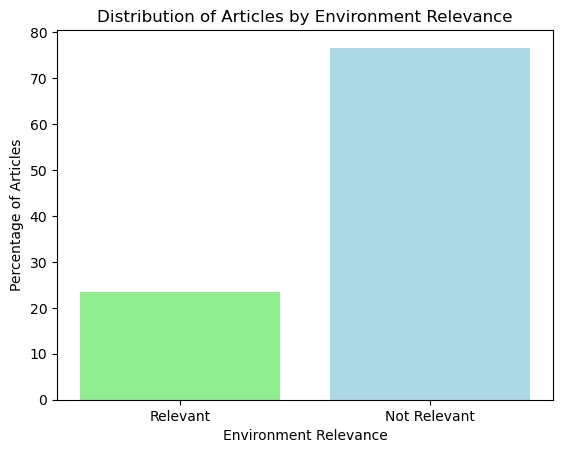

In [87]:
plt.bar(x = ['Relevant', 'Not Relevant'], height = [num_env_rel/num_class_articles * 100, num_non_env_rel/num_class_articles * 100], color = ['lightgreen', 'lightblue'])
plt.xlabel("Environment Relevance")
plt.ylabel("Percentage of Articles")
plt.title("Distribution of Articles by Environment Relevance")

### 5.2 Visualizing article sentiment for environment-relevant articles

Text(0.5, 1.0, 'Distribution of Article Sentiment over Environment-Relevant Articles')

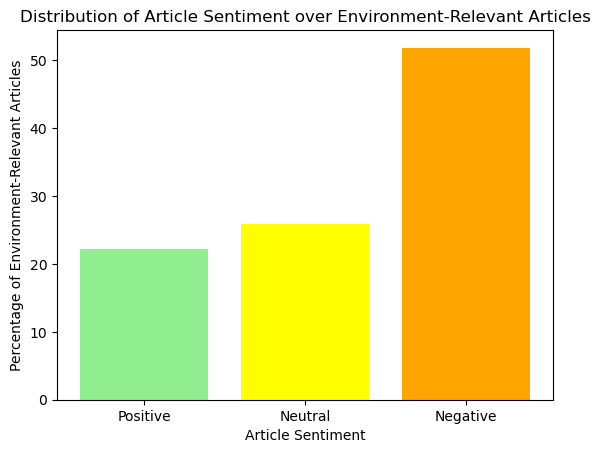

In [88]:
plt.bar(x = ['Positive', 'Neutral', 'Negative'], height = [num_env_rel_pos_sent/num_env_rel * 100, num_env_rel_neut_sent/num_env_rel * 100, num_env_rel_neg_sent/num_env_rel *100], color = ['lightgreen', 'yellow', 'orange'])
plt.xlabel("Article Sentiment")
plt.ylabel("Percentage of Environment-Relevant Articles")
plt.title("Distribution of Article Sentiment over Environment-Relevant Articles")

### 5.3 Visualizing waterway relevance for environment-relevant articles

#### 5.3.1 Visualizing waterway relevance for environment-relevant articles

In [89]:
num_ww_rel_env_rel_articles = len([article_dict for article_dict in env_rel_list if article_dict['waterway related'] == 'YES'])
print(f"Number of waterway relevant articles among environment relevant articles = {num_ww_rel_env_rel_articles}, Percentage = {round(num_ww_rel_env_rel_articles/num_env_rel*100, 2)}")

Number of waterway relevant articles among environment relevant articles = 39, Percentage = 72.22


Text(0.5, 1.0, 'Distribution of Waterway Relevance\nover Environment-Related Articles')

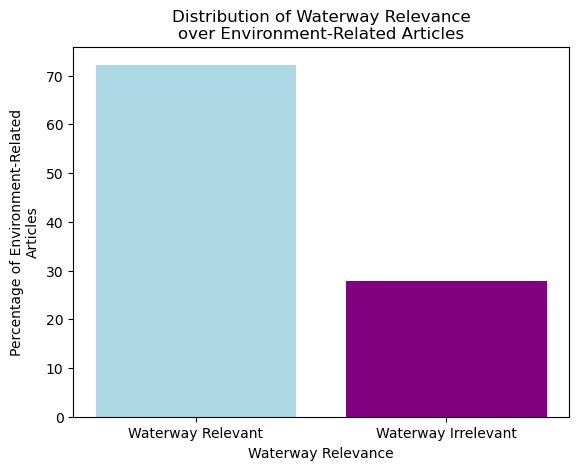

In [90]:
plt.bar(x = ['Waterway Relevant', 'Waterway Irrelevant'], height = [num_ww_rel_env_rel_articles/num_env_rel*100, num_ww_irrel_env_rel_articles/num_env_rel*100], color = ['lightblue', 'purple'])
plt.xlabel("Waterway Relevance")
plt.ylabel("Percentage of Environment-Related\nArticles")
plt.title("Distribution of Waterway Relevance\nover Environment-Related Articles")

#### 5.3.2 Visualizing waterway relevance for environment-relevant articles with negative sentiment

Text(0.5, 1.0, 'Distribution of Waterway Relevance\nover Environment-Related Negative Articles')

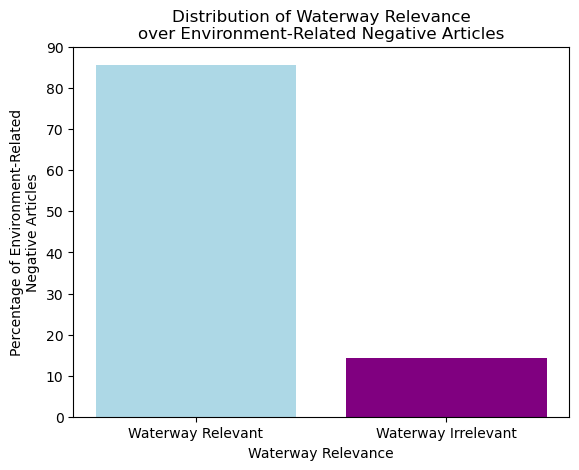

In [91]:
plt.bar(x = ['Waterway Relevant', 'Waterway Irrelevant'], height = [num_ww_rel_env_rel_neg_articles/num_env_rel_neg_sent*100, num_ww_irrel_env_rel_neg_articles/num_env_rel_neg_sent*100], color = ['lightblue', 'purple'])
plt.xlabel("Waterway Relevance")
plt.ylabel("Percentage of Environment-Related\nNegative Articles")
plt.title("Distribution of Waterway Relevance\nover Environment-Related Negative Articles")

### 5.4 Time-Series Plots

#### 5.4.1 Time-series distribution of articles based on environment relevance

In [92]:
#min_date = min([pd.to_datetime(article_dict['publishedAt']).strftime("%Y-%m") for article_dict in image_rel_articles_classified_list])
min_month = min([pd.to_datetime(article_dict['publishedAt']).to_period('M') for article_dict in image_rel_articles_classified_list])
max_month = max([pd.to_datetime(article_dict['publishedAt']).to_period('M') for article_dict in image_rel_articles_classified_list])
print(f"Earliest article is from {min_month}.")
print(f"Latest article is from {max_month}.")

months_x_axis_list = []
num_env_rel_articles_y_axis_list = []
cum_num_articles_y_axis_list = []
curr_month = min_month
while curr_month <= max_month:

    curr_month_env_rel_article_arr = np.array([pd.to_datetime(article_dict['publishedAt']).to_period('M') for article_dict in env_rel_list])
    curr_month_env_rel_article_num = np.sum(curr_month_env_rel_article_arr == curr_month)

    curr_month_non_env_rel_article_arr = np.array([pd.to_datetime(article_dict['publishedAt']).to_period('M') for article_dict in non_env_rel_list])
    curr_month_non_env_rel_article_num = np.sum(curr_month_non_env_rel_article_arr == curr_month)

    months_x_axis_list.append(str(curr_month))
    num_env_rel_articles_y_axis_list.append(curr_month_env_rel_article_num)
    cum_num_articles_y_axis_list.append(curr_month_env_rel_article_num + curr_month_non_env_rel_article_num)

    #print(f"Month: {curr_month}")
    #print(f"Number of environment relevant articles = {curr_month_env_rel_article_num}")
    #print(f"Number of non-environment relevant articles = {curr_month_non_env_rel_article_num}")
    #print("------------------------------------------------")
    
    curr_month += 1

print(months_x_axis_list)
print(num_env_rel_articles_y_axis_list)
print(cum_num_articles_y_axis_list)

C:\Users\draw0004\AppData\Local\Temp\ipykernel_26224\4079898317.py:2: UserWarning: Converting to Period representation will drop timezone information.
  min_month = min([pd.to_datetime(article_dict['publishedAt']).to_period('M') for article_dict in image_rel_articles_classified_list])
C:\Users\draw0004\AppData\Local\Temp\ipykernel_26224\4079898317.py:3: UserWarning: Converting to Period representation will drop timezone information.
  max_month = max([pd.to_datetime(article_dict['publishedAt']).to_period('M') for article_dict in image_rel_articles_classified_list])
C:\Users\draw0004\AppData\Local\Temp\ipykernel_26224\4079898317.py:13: UserWarning: Converting to Period representation will drop timezone information.
  curr_month_env_rel_article_arr = np.array([pd.to_datetime(article_dict['publishedAt']).to_period('M') for article_dict in env_rel_list])
C:\Users\draw0004\AppData\Local\Temp\ipykernel_26224\4079898317.py:16: UserWarning: Converting to Period representation will drop timezon

Earliest article is from 2023-08.
Latest article is from 2024-08.
['2023-08', '2023-09', '2023-10', '2023-11', '2023-12', '2024-01', '2024-02', '2024-03', '2024-04', '2024-05', '2024-06', '2024-07', '2024-08']
[3, 2, 1, 1, 4, 1, 0, 0, 8, 0, 10, 23, 1]
[4, 14, 4, 4, 6, 11, 14, 18, 38, 14, 34, 58, 12]


Text(0.5, 1.0, 'Articles by Environment-Relevance Published in the Year Leading Up to the Olympics')

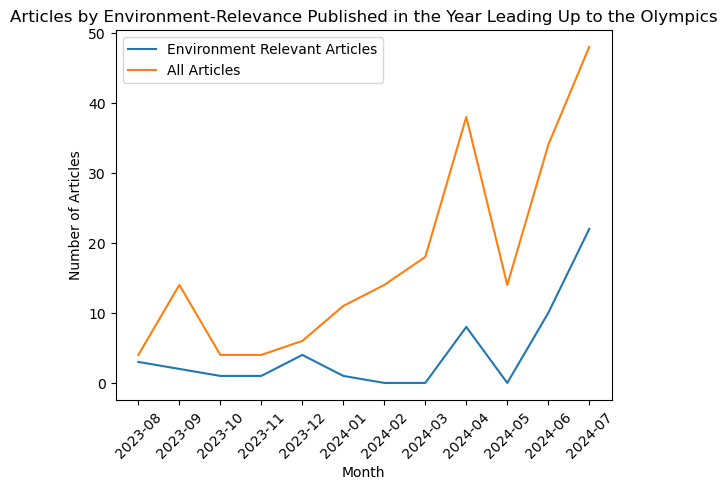

In [55]:
plt.plot(months_x_axis_list, num_env_rel_articles_y_axis_list, '-', label = "Environment Relevant Articles")
plt.plot(months_x_axis_list, cum_num_articles_y_axis_list, '-', label = "All Articles")
plt.legend()
plt.xlabel("Month")
plt.xticks(rotation=45)
plt.ylabel("Number of Articles")
plt.title("Articles by Environment-Relevance Published in the Year Leading Up to the Olympics")

#### 5.4.2 Time-series distribution of environment relevant articles based on waterway relevance

In [93]:
num_ww_rel_env_rel_articles = len([article_dict for article_dict in env_rel_list if article_dict['waterway related'] == 'YES'])
print(f"Number of waterway relevant articles among environment relevant articles = {num_ww_rel_env_rel_articles}, Percentage = {round(num_ww_rel_env_rel_articles/num_env_rel*100, 2)}")

Number of waterway relevant articles among environment relevant articles = 39, Percentage = 72.22


In [94]:
#min_date = min([pd.to_datetime(article_dict['publishedAt']).strftime("%Y-%m") for article_dict in image_rel_articles_classified_list])
min_month = min([pd.to_datetime(article_dict['publishedAt']).to_period('M') for article_dict in env_rel_list])
max_month = max([pd.to_datetime(article_dict['publishedAt']).to_period('M') for article_dict in env_rel_list])
print(f"Earliest article is from {min_month}.")
print(f"Latest article is from {max_month}.")

months_x_axis_list = []
num_ww_rel_articles_y_axis_list = []
cum_num_env_rel_articles_y_axis_list = []
curr_month = min_month
while curr_month <= max_month:

    curr_month_ww_rel_article_arr = np.array([pd.to_datetime(article_dict['publishedAt']).to_period('M') for article_dict in env_rel_list if article_dict['waterway related'] == 'YES'])
    curr_month_ww_rel_article_num = np.sum(curr_month_ww_rel_article_arr == curr_month)
    
    curr_month_ww_irrel_article_arr = np.array([pd.to_datetime(article_dict['publishedAt']).to_period('M') for article_dict in env_rel_list if article_dict['waterway related'] == 'NO'])
    curr_month_ww_irrel_article_num = np.sum(curr_month_ww_irrel_article_arr == curr_month)

    months_x_axis_list.append(str(curr_month))
    num_ww_rel_articles_y_axis_list.append(curr_month_ww_rel_article_num)
    cum_num_env_rel_articles_y_axis_list.append(curr_month_ww_rel_article_num + curr_month_ww_irrel_article_num)
    
    curr_month += 1

print(months_x_axis_list)
print(num_ww_rel_articles_y_axis_list)
print(cum_num_env_rel_articles_y_axis_list)

C:\Users\draw0004\AppData\Local\Temp\ipykernel_26224\4037091985.py:2: UserWarning: Converting to Period representation will drop timezone information.
  min_month = min([pd.to_datetime(article_dict['publishedAt']).to_period('M') for article_dict in env_rel_list])
C:\Users\draw0004\AppData\Local\Temp\ipykernel_26224\4037091985.py:3: UserWarning: Converting to Period representation will drop timezone information.
  max_month = max([pd.to_datetime(article_dict['publishedAt']).to_period('M') for article_dict in env_rel_list])
C:\Users\draw0004\AppData\Local\Temp\ipykernel_26224\4037091985.py:13: UserWarning: Converting to Period representation will drop timezone information.
  curr_month_ww_rel_article_arr = np.array([pd.to_datetime(article_dict['publishedAt']).to_period('M') for article_dict in env_rel_list if article_dict['waterway related'] == 'YES'])
C:\Users\draw0004\AppData\Local\Temp\ipykernel_26224\4037091985.py:16: UserWarning: Converting to Period representation will drop timezon

Earliest article is from 2023-08.
Latest article is from 2024-08.
['2023-08', '2023-09', '2023-10', '2023-11', '2023-12', '2024-01', '2024-02', '2024-03', '2024-04', '2024-05', '2024-06', '2024-07', '2024-08']
[3, 0, 1, 1, 3, 1, 0, 0, 6, 0, 6, 17, 1]
[3, 2, 1, 1, 4, 1, 0, 0, 8, 0, 10, 23, 1]


Text(0.5, 1.0, 'Enviroment Relevant Articles by Waterway-Relevance\nPublished in the Year Leading Up to the Olympics')

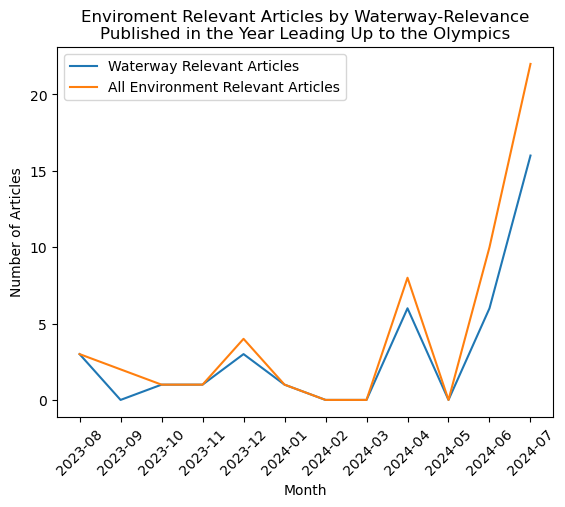

In [58]:
plt.plot(months_x_axis_list, num_ww_rel_articles_y_axis_list, '-', label = "Waterway Relevant Articles")
plt.plot(months_x_axis_list, cum_num_env_rel_articles_y_axis_list, '-', label = "All Environment Relevant Articles")
plt.legend()
plt.xlabel("Month")
plt.xticks(rotation=45)
plt.ylabel("Number of Articles")
plt.title("Enviroment Relevant Articles by Waterway-Relevance\nPublished in the Year Leading Up to the Olympics")